In [42]:
import os
import copy
import pickle
import numpy as np
import glob

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# astropy
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.coordinates import SkyCoord, Angle
from astropy import wcs
from astropy.table import Table,vstack
import astropy.units as u
import matplotlib.pyplot as plt 

#from candels_galaxy_surveys import galaxy_catalog,galaxy_survey

__current_dir__=os.path.abspath(os.getcwd())


__merged_data_dir__=os.path.join(__current_dir__,'data/merged/') 

candels_Ias = pickle.load(open(os.path.join(__merged_data_dir__,'candels_Ias.pkl'),'rb'))
candels_CCs = pickle.load(open(os.path.join(__merged_data_dir__,'candels_CCs.pkl'),'rb'))
candels_SNs = pickle.load(open(os.path.join(__merged_data_dir__,'candels_SNs.pkl'),'rb'))

goods_Ias = pickle.load(open(os.path.join(__merged_data_dir__,'goods_Ias.pkl'),'rb'))
goods_CCs = pickle.load(open(os.path.join(__merged_data_dir__,'goods_CCs.pkl'),'rb'))

lcs_unmatched = pickle.load(open(os.path.join(__merged_data_dir__,'lcs_unmatched.pkl'),'rb'))

hopefully have the last element in the merged catalog now is a table of lc data, however...

If the merged catalog has empty last element then it didn't find a matching lc to merge with

& if had a lc which didn't find a matching catalog it was put into the lcs_unmatched so its not left behind

In [46]:
CC_lcs = []
CC_names = []
for i in range(len(candels_CCs)):
    CC_lcs.append(candels_CCs[i][-1])
    CC_names.append(candels_CCs[i][0]['name'])
for i in range(len(goods_CCs)):
    CC_lcs.append(goods_CCs[i][-1])
    CC_names.append(goods_CCs[i][0]['name'])
    

Ia_lcs = []
Ia_names = []
for i in range(len(candels_Ias)):
    Ia_names.append(candels_Ias[i][0]['name'])
    Ia_lcs.append(candels_Ias[i][-1])
for i in range(len(goods_Ias)):
    Ia_names.append(goods_Ias[i][0]['name'])
    Ia_lcs.append(goods_Ias[i][-1])

In [55]:
for i in range(len(Ia_lcs)):
    lightcurve_model = []
    
    # didn't have the matching lc for the catalog, empty list where data table would've been...
    # can't be fit 
    if len(Ia_lcs[i]) == 0:
        
        lightcurve_model.append([Ia_lcs[i],['no result','no model']])
        name = Ia_names[i]
        
        #print(i,'no lc')
        
        pickle.dump(lightcurve_model,open('results/candelsIa/no/'+name+'.pkl','wb'))
    
    # Had the matching lc for the catalog can actually model 
    elif len(Ia_lcs[i]) > 0:
        
        # occasionally there were multiple lc tables for same sn; they were the same just take the zeroth  
        tab = Ia_lcs[i][0]
        lightcurve_model.append(tab)
        
        name =  Ia_names[i]
        
        model = sncosmo.Model(source='salt2')

        # Only fit to these bands
        dat = copy.copy(tab)
        tmp = list(np.arange(len(dat)))
        for i in range(len(dat)):
            if dat[i]['band'] == 'F160W':
                tmp.remove(i)
            elif dat[i]['band'] == 'F140W':
                tmp.remove(i)
            elif dat[i]['band'] == 'F125W':
                tmp.remove(i)
            elif dat[i]['band'] == 'F110W':
                tmp.remove(i)
            elif dat[i]['band'] == 'F105W':
                tmp.remove(i)
            else: continue
        dat.remove_rows(tmp)
        

        # using initial redshift and bounds from previous fits available in table
        try:
            z = np.float(tab.meta['REDSHIFT_FINAL'][0])
            dz = np.float(tab.meta['REDSHIFT_FINAL'][2])
            zup = z + dz
            zlow = z - dz
        except:
            pass

        # include the dust extinction for lights path through milky way
        model.add_effect(sncosmo.CCM89Dust(),'mw','obs')
        try:
            ebv = np.float(tab.meta['MWEBV'][0])
            model.set(mwebv = ebv)
            #print(i,'including dust')
        except: pass

        # try to fit model
        try:
            result,fitted_model=sncosmo.fit_lc(
                dat ,model,
                ['z', 't0', 'x0', 'x1', 'c'],
                bounds={'z':(zlow,zup)})
            #print(i,'success')
            
            lightcurve_model.append([result,fitted_model])
            pickle.dump(lightcurve_model,open('results/candelsIa/success/'+name+'.pkl','wb'))

        except:
            [result,fitted_model] = ['failed result','failed model'] 
            #print(i,'failed')
            lightcurve_model.append([result,fitted_model])
            pickle.dump(lightcurve_model,open('results/candelsIa/failed/'+name+'.pkl','wb'))

        # Remaining is just plotting... using model to display the fit w data
        # will show a few examples in next cell
        # can follow steps of clashlc nb where the figures are shown 


In [68]:
egs11oba = pickle.load(open('results/candelsIa/success/EGS11Oba.pkl','rb'))

tab = egs11oba[0]
result = egs11oba[1][0]
fitted_model = egs11oba[1][1]


z = fitted_model.parameters[0]
t0 = fitted_model.parameters[1]
x1 = fitted_model.parameters[2]
x2 = fitted_model.parameters[3]
c = fitted_model.parameters[4]

dat = copy.copy(tab)
tmp = list(np.arange(len(dat)))
for i in range(len(dat)):
    if dat[i]['band'] == 'F160W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F140W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F125W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F110W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F105W':
        tmp.remove(i)
    else: continue
dat.remove_rows(tmp)

# need the data points/error bars to plot with model
# egs11oba has 125 and 160 data from wide IR filters
# others commented out; just uncomment if interested in another sn 
f160w = []
#f140w = []
f125w = []
#f110w = []
#f105w = []

# data
for i in dat:
    if i['band'] == 'F160W':
        f160w.append(i)
    elif i['band'] == 'F140W':
        f140w.append(i)
    elif i['band'] == 'F125W':
        f125w.append(i)
    elif i['band'] == 'F110W':
        f110w.append(i)
    elif i['band'] == 'F105W':
        f105w.append(i)
    else: print('not f125 or f160? should only have these remaining')
from astropy.table import vstack
f160w = vstack([i for i in  f160w])
#f140w = vstack([i for i in f140w])
f125w = vstack([i for i in f125w])
#f110w = vstack([i for i in f110w])
#f105w = vstack([i for i in f105w])

# data points y
flux_f160w = [i for i in f160w['flux']] 
#flux_f140w = [i for i in f140w['flux']]
flux_f125w = [i for i in f125w['flux']]
#flux_f110w = [i for i in f110w['flux']]
#flux_f105w = [i for i in f105w['flux']]

#error bars
dflux_f160w = [i for i in  f160w['fluxerr']]
#dflux_f140w = [i for i in f140w['fluxerr']]
dflux_f125w = [i for i in f125w['fluxerr']]
#dflux_f110w = [i for i in f110w['fluxerr']]
#dflux_f105w = [i for i in f105w['fluxerr']]

# data points x
t160w = [i for i in f160w['time']]
#t140w = [i for i in f140w['time']]
t125w = [i for i in f125w['time']]
#t110w = [i for i in f110w['time']]
#t105w = [i for i in f105w['time']]


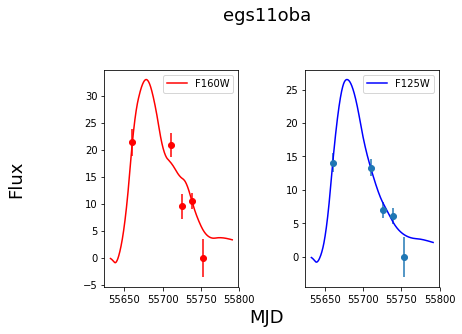

In [73]:
# may need to play with time to get plot looking good for each different case
t = np.linspace(t0 - 45,t0+115,10000)
fig, (ax1,ax2) = plt.subplots(1,2)
fig.text(0.5, 0.001, 'MJD', ha='center',size=18)
fig.text(-0.1, 0.5, 'Flux', va='center', rotation='vertical',size=18)
#txtstr = 'z =' + str(z)[:4] + '\n' 't0 = '+ str(t0)[:7] + '\n' + 'A = '+ str(np.format_float_scientific(A,precision=2))
#fig.text(.5,1.10,txtstr,va='center',size=18)

fig.text(0.4,1.05,'egs11oba',size=18)


ax1.plot(t,fitted_model.bandflux('F160W',t,zp=27.5,zpsys='VEGA'),label='F160W',color = 'red')
ax1.errorbar(t160w,flux_f160w,yerr = dflux_f160w,fmt='o',color='red')

ax2.plot(t,fitted_model.bandflux('F125W',t,zp=27.5,zpsys='VEGA'),label='F125W',color='blue')
ax2.errorbar(t125w,flux_f125w,yerr=dflux_f125w,fmt='o')

plt.subplots_adjust(wspace=0.5)
ax1.legend()
ax2.legend()